# <center> Objectifs Principaux </center>

- Centraliser les données dispersées dans plusieurs fichiers CSV.
- Créer de nouvelles variables (Feature Engineering) basées sur le temps de travail.
- Nettoyer le jeu de données en retirant les informations inutiles.

## 1. Sources de Données (Entrées)

Le script charge 5 fichiers distincts :

- general_data.csv : Informations démographiques et contractuelles.
- manager_survey_data.csv : Évaluations par les managers.
- employee_survey_data.csv : Satisfaction et avis des employés.
- in_time.csv : Horaires d'arrivée (badgeage entrant).
- out_time.csv : Horaires de départ (badgeage sortant).

## 2. Étapes de Transformation 

### A. Fusion des Données Statiques

Le script commence par fusionner les données générales avec les deux enquêtes (Manager et Employé) en utilisant la clé unique EmployeeID.
Type de jointure : Left Merge (pour conserver tous les employés listés dans le fichier général).

### B. Ingénierie des Données Temporelles (Badgeuse)
C'est l'étape la plus complexe du script, traitant in_time et out_time :

Indexation : Définit EmployeeID comme index pour aligner les matrices.

Conversion : Transforme les chaînes de caractères en objets datetime.

Calcul de durée :
$$\text{Durée} = \text{Heure de Départ} - \text{Heure d'Arrivée}$$
Création de métriques agrégées (Features) :
- AverageWorkingHours : La moyenne des heures travaillées par jour (excluant les absences).
- TotalWorkingDays : Le nombre total de jours où l'employé a badgé dans l'année.

### C. Fusion Finale et Nettoyage

Les métriques temporelles sont ajoutées au DataFrame principal.
Suppression des constantes : Le script identifie et supprime toutes les colonnes qui ne contiennent qu'une seule valeur unique (ex: "Over18" = 'Y' pour tous), car elles n'apportent aucune variance pour un modèle prédictif.

## 3. Sortie (Output)

Un tableau unique contenant toutes les informations consolidées, nettoyées et enrichies des nouvelles métriques de temps.

In [1]:
# IMPORTS
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:

def process_hr_data():
    # 1. Chargement des données
    print("Chargement des fichiers...")
    general_data = pd.read_csv('data/general_data.csv')
    manager_survey = pd.read_csv('data/manager_survey_data.csv')
    employee_survey = pd.read_csv('data/employee_survey_data.csv')
    in_time = pd.read_csv('data/in_time.csv')
    out_time = pd.read_csv('data/out_time.csv')
    # 2. Fusion des données principales
    # On utilise EmployeeID comme clé de jointure
    df_main = general_data.merge(manager_survey, on='EmployeeID', how='left')
    df_main = df_main.merge(employee_survey, on='EmployeeID', how='left')

    # 3. Traitement des fichiers Temps (Badgeuse)
    # Renommer la première colonne vide ou index en 'EmployeeID'
    in_time.rename(columns={in_time.columns[0]: 'EmployeeID'}, inplace=True)
    out_time.rename(columns={out_time.columns[0]: 'EmployeeID'}, inplace=True)

    # Définir l'index pour faciliter les calculs matriciels
    in_time.set_index('EmployeeID', inplace=True)
    out_time.set_index('EmployeeID', inplace=True)

    print("Traitement des horaires (conversion et calcul)...")
    # Conversion en datetime (ignorer les erreurs pour les jours fériés/absences)
    processed_in = in_time.apply(pd.to_datetime, errors='coerce')
    processed_out = out_time.apply(pd.to_datetime, errors='coerce')

    # Calcul de la durée de travail journalière
    duration = processed_out - processed_in
    # Conversion en heures
    duration_hours = duration.apply(lambda x: x.dt.total_seconds() / 3600)

    # Création des nouvelles métriques
    # Moyenne des heures travaillées par jour (en ignorant les NaN/absences)
    mean_hours = duration_hours.mean(axis=1)
    # Nombre total de jours travaillés dans l'année
    working_days = duration_hours.count(axis=1)

    # Création du DataFrame des features temporelles
    time_features = pd.DataFrame({
        'EmployeeID': in_time.index,
        'AverageWorkingHours': mean_hours.values,
        'TotalWorkingDays': working_days.values
    })

    # 4. Fusion finale
    final_df = df_main.merge(time_features, on='EmployeeID', how='left')

    # 5. Nettoyage
    # Suppression des colonnes qui n'ont qu'une seule valeur (inutiles pour le modèle)
    # Exemple: 'Over18' est 'Y' pour tout le monde, 'StandardHours' est 8 pour tout le monde.
    nunique = final_df.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    final_df.drop(columns=cols_to_drop, inplace=True)

    print(f"Colonnes supprimées (valeur constante) : {list(cols_to_drop)}")
    print(f"Taille finale du dataset : {final_df.shape}")

    # 6. Export
    final_df.to_csv('data/processed_hr_data.csv', index=False)
    print("Fichier 'processed_hr_data.csv' généré avec succès.")

    return final_df

# Exécution
if __name__ == "__main__":
    df = process_hr_data()
    print(df.head())

Chargement des fichiers...
Traitement des horaires (conversion et calcul)...
Colonnes supprimées (valeur constante) : ['EmployeeCount', 'Over18', 'StandardHours']
Taille finale du dataset : (4410, 28)
Fichier 'processed_hr_data.csv' généré avec succès.
   Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   51        No      Travel_Rarely                   Sales                 6   
1   31       Yes  Travel_Frequently  Research & Development                10   
2   32        No  Travel_Frequently  Research & Development                17   
3   38        No         Non-Travel  Research & Development                 2   
4   32        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeID  Gender  JobLevel  ... YearsAtCompany  \
0          2  Life Sciences           1  Female         1  ...              1   
1          1  Life Sciences           2  Female         1  ...              5   
2          4     

# <center> Objectifs Principaux </center>

Nettoyer les dernières imperfections (valeurs manquantes, identifiants).

Encoder les variables textuelles en valeurs numériques.
Générer deux versions du dataset : 
- Une version brute *(pour les arbres de décision)*
- Une version normalisée *(pour les réseaux de neurones/KNN)*

## Étapes de Transformation 

### A. Nettoyage et ImputationSuppression d'ID
La colonne EmployeeID est retirée (car elle n'a pas de valeur prédictive et pourrait biaiser le modèle).

Gestion des NaN : Les valeurs manquantes dans les colonnes numériques sont remplacées par la moyenne de la colonne (mean imputation).

### B. Traitement de la Cible (Target)

La variable Attrition est convertie en binaire : $Yes \rightarrow 1 / No \rightarrow 0$. <br>
Encodage des Variables CatégoriellesLe script distingue deux types de variables pour appliquer la stratégie adaptée : Variables Ordinales (Hiérarchie)
- Concerne : BusinessTravel.
- Méthode : Mapping manuel pour conserver l'ordre d'intensité.
- Mapping : Non-Travel ($0$) < Travel_Rarely ($1$) < Travel_Frequently ($2$).Variables Nominales (Pas d'ordre)
- Concerne : Department, EducationField, Gender, JobRole, MaritalStatus.
- Méthode : One-Hot Encoding (`pd.get_dummies`).
- Résultat : Création de colonnes binaires (ex: Gender_Female = 0 ou 1).

## Sorties (Outputs) : 

La Stratégie DoubleLe script génère deux fichiers distincts pour répondre aux besoins de différents algorithmes.

In [3]:
# 1. Chargement des données
df = pd.read_csv('data/processed_hr_data.csv')

# 2. Nettoyage initial
if 'EmployeeID' in df.columns:
    df = df.drop(columns=['EmployeeID'])

# Remplissage des valeurs manquantes (uniquement sur les colonnes numériques)
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# 3. Traitement de la cible (Target)
if 'Attrition' in df.columns:
    df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# 4. Traitement des variables catégorielles

# A) Variable Ordinale (Ordre important) : BusinessTravel
# On map manuellement pour respecter la hiérarchie : Non < Rare < Frequent
travel_map = {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
if 'BusinessTravel' in df.columns:
    df['BusinessTravel'] = df['BusinessTravel'].map(travel_map)

# B) Variables Nominales (Pas d'ordre) : One-Hot Encoding
# Cela va créer des colonnes comme 'Department_Sales', 'Department_HR', etc.
nominal_cols = ['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
# On vérifie que les colonnes existent bien
nominal_cols = [c for c in nominal_cols if c in df.columns]

# On applique le One-Hot Encoding (pd.get_dummies)
df_encoded = pd.get_dummies(df, columns=nominal_cols)
# On convertit tout en nombres (0.0 / 1.0) pour être sûr
df_encoded = df_encoded.astype(float)

# --- GÉNÉRATION DES DEUX FICHIERS ---

# FICHIER 1 : Non Normalisé (Brut mais encodé)
# Utile pour Random Forest, XGBoost, interprétation métier.
# Les salaires restent à 50000, l'âge à 30, etc.
df_not_normalized = df_encoded.copy()
df_not_normalized.to_csv('data/processed_hr_data_encoded_raw.csv', index=False)

# FICHIER 2 : Normalisé (0-1)
# Utile pour Réseaux de Neurones, KNN, Régression Logistique.
# Toutes les valeurs sont ramenées entre 0 et 1.
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)
df_normalized.to_csv('data/processed_hr_data_encoded_normalized.csv', index=False)

print("Traitement terminé.")
print(f"Colonnes générées ({len(df_encoded.columns)}) :")
print(df_encoded.columns.tolist())

Traitement terminé.
Colonnes générées (45) :
['Age', 'Attrition', 'BusinessTravel', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'AverageWorkingHours', 'TotalWorkingDays', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales', 'EducationField_Human Resources', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'Gender_Female', 'Gender_Male', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executi

# <center> Génération de Données Synthétiques </center>

  - Créer un jeu de données *anonymisé et normalisé* de toute pièce.
  - Simuler la structure exacte du fichier final sans utiliser de données réelles (GDPR/Confidentialité).
  - Garantir la cohérence mathématique des variables encodées (One-Hot).

## 1\. Méthodologie de Génération

Le script génère un DataFrame de **X lignes** en appliquant deux stratégies distinctes selon le type de variable.

### A. Variables Continues et Ordinales

Pour les colonnes comme l'âge, le salaire, ou les niveaux de satisfaction, le script simule des données déjà normalisées.

  - **Méthode :** Distribution uniforme aléatoire.
  - **Formule :** $X \sim \mathcal{U}(0, 1)$
  - **Exception :** La variable cible `Attrition` est générée de manière binaire ($0$ ou $1$).

### B. Variables Catégorielles (One-Hot Encoded)

C'est la partie critique. Pour des groupes comme `Department` (Sales, HR, R\&D), on ne peut pas générer des 0 et 1 au hasard, car un employé ne peut pas appartenir à trois départements en même temps.

  - **Contrainte d'exclusion mutuelle :** Pour un groupe de colonnes donné (ex: Department\_\*), la somme doit être égale à 1 pour chaque ligne.
  - **Logique :**
    1.  Choisir une catégorie aléatoire parmi les options disponibles.
    2.  Assigner $1.0$ à la colonne correspondante.
    3.  Assigner $0.0$ aux autres colonnes du groupe.

## 2\. Sortie (Output)

Un fichier CSV `processed_fake_hr_data_encoded_normalized.csv` prêt à être injecté dans un modèle de Machine Learning (Réseau de Neurones, SVM) pour tester le pipeline technique sans exposer de données sensibles.

In [4]:
def generate_fake_normalized_data(num_rows=2000):
    # 1. Liste des colonnes continues et ordinales (non one-hot)
    # Ces colonnes recevront des valeurs aléatoires entre 0 et 1
    numeric_cols = [
        'Age', 'Attrition', 'BusinessTravel', 'DistanceFromHome', 'Education', 'JobLevel',
        'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel',
        'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
        'YearsWithCurrManager', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction',
        'JobSatisfaction', 'WorkLifeBalance', 'AverageWorkingHours', 'TotalWorkingDays'
    ]
    
    # Initialisation du dictionnaire de données
    data = {}
    
    # Génération des données pour les colonnes numériques
    for col in numeric_cols:
        if col == 'Attrition':
            # Cas spécifique binaire (0 ou 1)
            data[col] = np.random.choice([0.0, 1.0], num_rows)
        else:
            # Distribution uniforme entre 0 et 1 pour simuler la normalisation
            data[col] = np.random.uniform(0, 1, num_rows)

    # Création du DataFrame initial
    df = pd.DataFrame(data)

    # 2. Gestion des groupes One-Hot Encoding (exclusivité mutuelle)
    # Pour chaque groupe, une seule colonne doit être à 1, les autres à 0.
    one_hot_groups = {
        'Department': ['Human Resources', 'Research & Development', 'Sales'],
        'EducationField': ['Human Resources', 'Life Sciences', 'Marketing', 'Medical', 'Other', 'Technical Degree'],
        'Gender': ['Female', 'Male'],
        'JobRole': ['Healthcare Representative', 'Human Resources', 'Laboratory Technician', 'Manager', 
                    'Manufacturing Director', 'Research Director', 'Research Scientist', 'Sales Executive', 
                    'Sales Representative'],
        'MaritalStatus': ['Divorced', 'Married', 'Single']
    }

    for prefix, categories in one_hot_groups.items():
        # On choisit aléatoirement un index de catégorie pour chaque ligne
        random_indices = np.random.randint(0, len(categories), num_rows)
        
        for i, cat in enumerate(categories):
            col_name = f"{prefix}_{cat}"
            # La colonne vaut 1.0 si l'index correspond, sinon 0.0
            df[col_name] = (random_indices == i).astype(float)

    return df

# Génération de deux jeux de données de tailles différentes

# Fichier de 2000 lignes
df_2000 = generate_fake_normalized_data(num_rows=2000)
df_2000.to_csv('data/processed_fake_hr_data_encoded_normalized_2000.csv', index=False)

# Fichier de 4000 lignes
df_4000 = generate_fake_normalized_data(num_rows=4000)
df_4000.to_csv('data/processed_fake_hr_data_encoded_normalized_4000.csv', index=False)

# <center> Objectifs Principaux </center>

1.  **Reconstruire des labels lisibles** à partir des données encodées (ex: retrouver le nom du métier).
2.  **Calculer des statistiques descriptives** sur les variables continues.
3.  **Générer 5 graphiques clés** pour diagnostiquer les causes de départ, en appliquant les bonnes pratiques récentes de la librairie *Seaborn*.

## 1. Entrée

  * **Source :** `processed_hr_data_encoded_raw.csv`
      * *Note :* Le script utilise la version "Raw" (non normalisée) car elle contient les vraies valeurs (Âge réel, Salaire réel), ce qui est nécessaire pour des graphiques interprétables.

## 2. Préparation des Données pour l'Affichage

Avant de tracer les graphiques, le script effectue une "rétro-ingénierie" pour rendre les données plus visuelles :

  * **Étiquetage de la Cible :** Crée une colonne `Attrition_Label` ('Yes'/'No') pour les légendes.
  * **Reconstruction du JobRole :**
      * Les données sont actuellement en *One-Hot Encoding* (JobRole\_Sales, JobRole\_HR...).
      * Le script utilise `idxmax()` pour retrouver le nom de la colonne active et recréer une colonne catégorielle unique `JobRole_Reconstructed`.


## 3. Analyses et Visualisations Générées

Le script produit une série d'analyses statistiques et graphiques :

### A. Tableau Statistique (Hors Binaires)

Il filtre les colonnes purement binaires (0/1) pour se concentrer sur les variables numériques (Salaire, Âge, Années).

  * **Calculs :** Moyenne, Médiane, Min, Max, Écart-type.
  * **Visualisation :** Affiche un tableau textuel et une **Heatmap** des statistiques pour une lecture rapide.

### B. Les 5 Graphiques Clés

| Graphique | Type | Objectif Analytique | Détail Technique (Fix Seaborn) |
| :--- | :--- | :--- | :--- |
| **1. Répartition Globale** | `Countplot` | Vérifier le déséquilibre des classes (Combien de départs vs restants ?). | Ajout de `hue='Attrition_Label'` pour éviter les warnings futurs. |
| **2. Départ par Métier** | `Barplot` | Identifier les métiers les plus à risque. Calcule le taux : $\frac{\text{Départs}}{\text{Total}} \times 100$. | Tri décroissant pour mettre en avant les zones critiques. |
| **3. Heures de Travail** | `Boxplot` | Corréler le volume horaire avec le départ (Burnout ?). | Compare la distribution des heures entre ceux qui partent et ceux qui restent. |
| **4. Ancienneté** | `KDE Plot` | Voir à quel moment de la carrière les gens partent (Distribution de densité). | Superposition des courbes (Rouge = Départ, Bleu = Reste). |
| **5. Corrélations** | `Heatmap` | Identifier les liens linéaires forts entre l'attrition et les variables numériques. | Focus sur les 10 premières variables numériques pour la lisibilité. |

--- STATISTIQUES DES DONNÉES (HORS 0/1) ---
                                 mean        median           min  \
Age                         36.923810     36.000000     18.000000   
BusinessTravel               1.086395      1.000000      0.000000   
DistanceFromHome             9.192517      7.000000      1.000000   
Education                    2.912925      3.000000      1.000000   
JobLevel                     2.063946      2.000000      1.000000   
MonthlyIncome            65029.312925  49190.000000  10090.000000   
NumCompaniesWorked           2.694830      2.000000      0.000000   
PercentSalaryHike           15.209524     14.000000     11.000000   
StockOptionLevel             0.793878      1.000000      0.000000   
TotalWorkingYears           11.279936     10.000000      0.000000   
TrainingTimesLastYear        2.799320      3.000000      0.000000   
YearsAtCompany               7.008163      5.000000      0.000000   
YearsSinceLastPromotion      2.187755      1.000000      0.

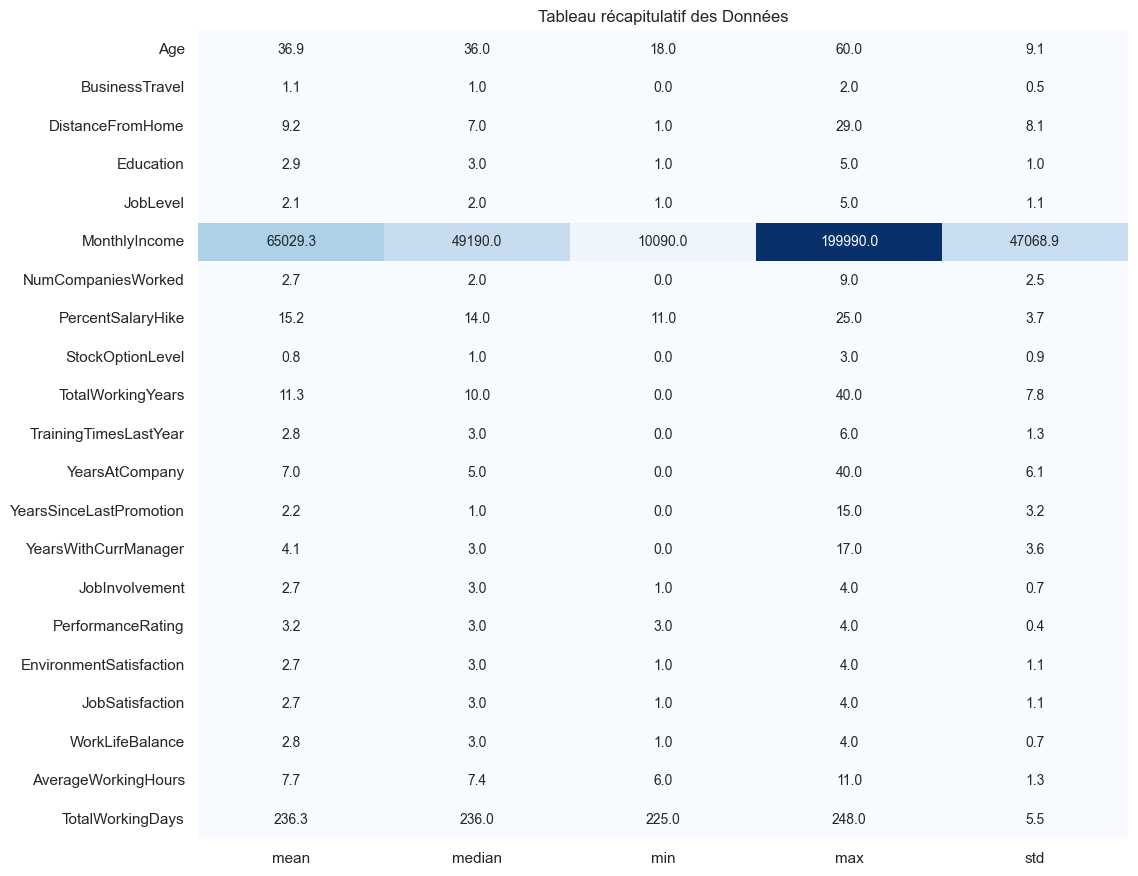

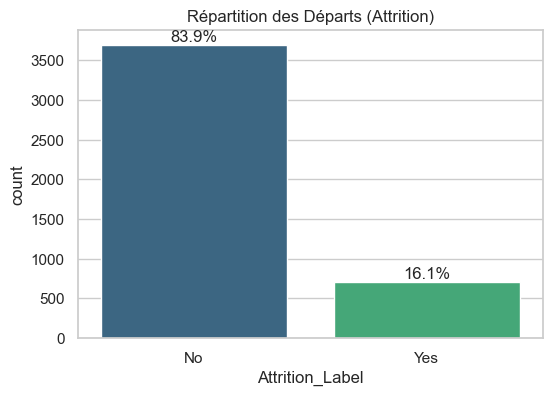

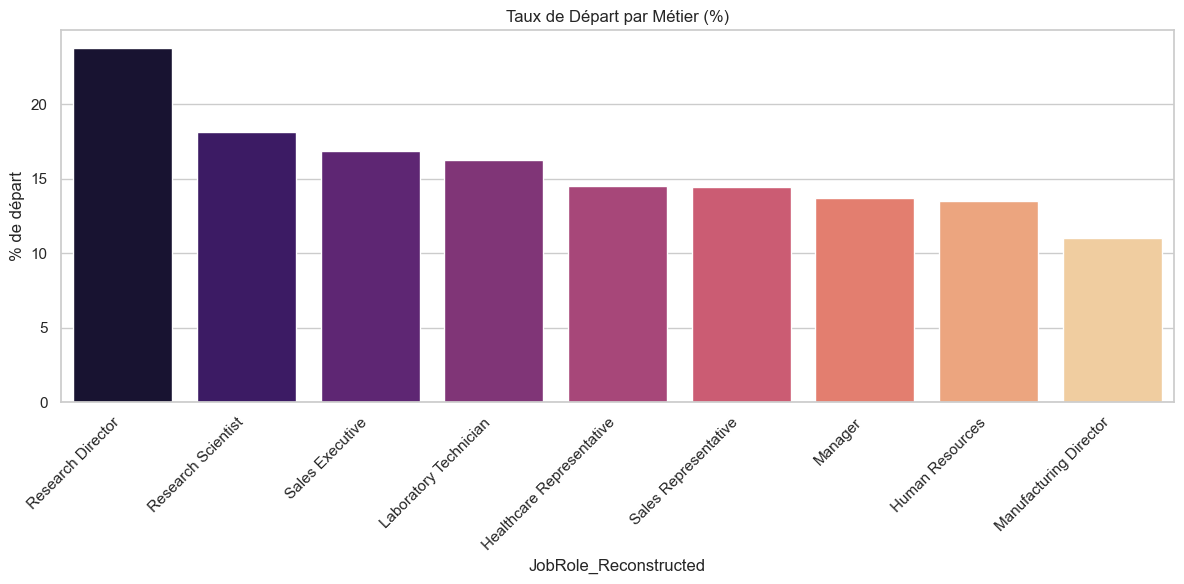

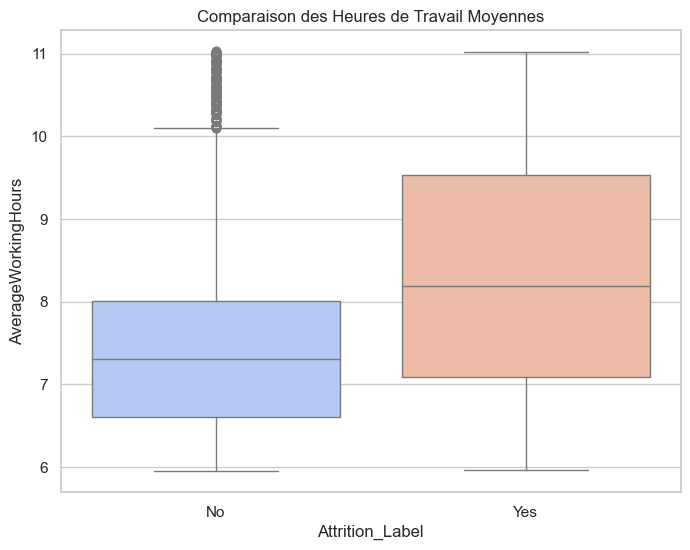

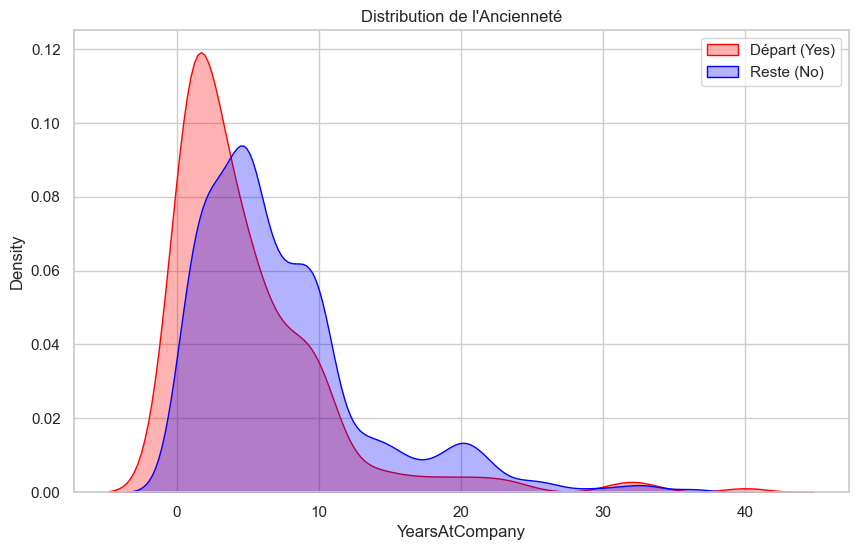

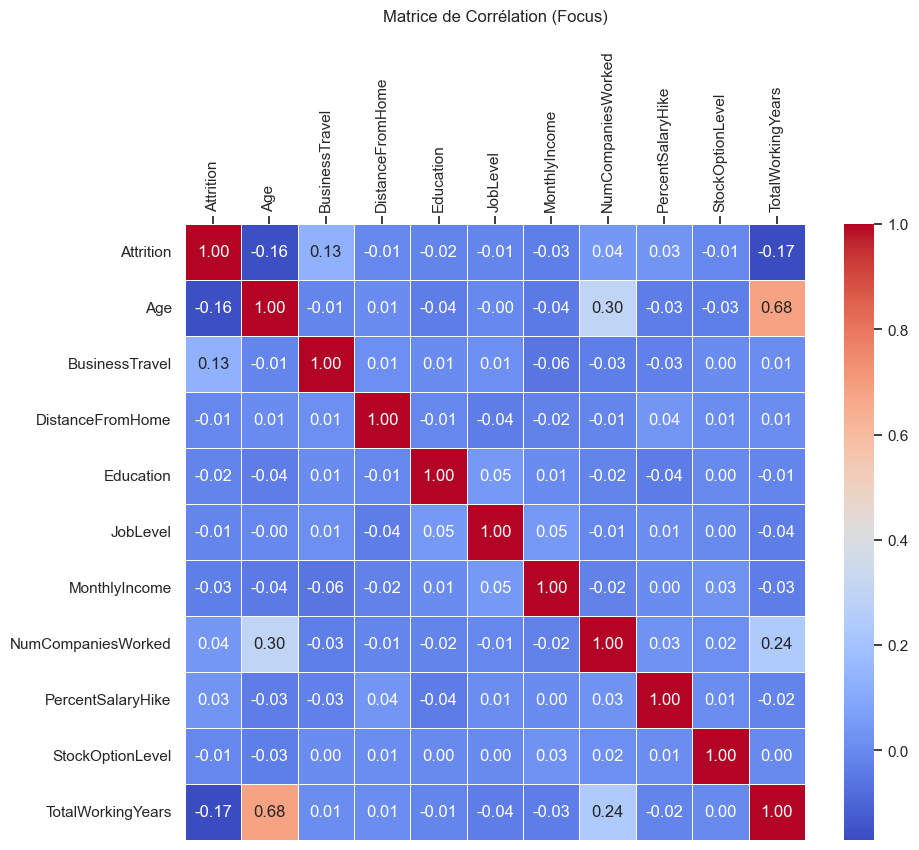

In [5]:
def analyze_and_show():
    # 1. Chargement des données encodées (mais non normalisées)
    # Assurez-vous que le chemin est correct
    try:
        df = pd.read_csv('processed_hr_data_encoded_raw.csv')
    except FileNotFoundError:
        df = pd.read_csv('data/processed_hr_data_encoded_raw.csv') # Fallback si dossier data
    
    # --- PRÉPARATION POUR L'AFFICHAGE ---
    # Recréation des labels pour la lisibilité
    if 'Attrition' in df.columns:
        df['Attrition_Label'] = df['Attrition'].map({0: 'No', 1: 'Yes'})
    
    # Reconstruction de JobRole pour les graphes
    job_role_cols = [c for c in df.columns if c.startswith('JobRole_')]
    if job_role_cols:
        df['JobRole_Reconstructed'] = df[job_role_cols].idxmax(axis=1).str.replace('JobRole_', '')

    # Configuration du style
    sns.set(style="whitegrid")

    # ==============================================================================
    # TABLEAU DE STATISTIQUES (SAUF BINAIRES 0/1)
    # ==============================================================================
    print("--- STATISTIQUES DES DONNÉES (HORS 0/1) ---")
    
    non_binary_cols = []
    for col in df.select_dtypes(include=['number']).columns:
        unique_vals = set(df[col].dropna().unique())
        if not unique_vals.issubset({0, 1}):
            non_binary_cols.append(col)
    
    stats_df = df[non_binary_cols].describe().T
    stats_df['median'] = df[non_binary_cols].median()
    
    display_cols = ['mean', 'median', 'min', 'max', 'std']
    print(stats_df[display_cols])
    
    plt.figure(figsize=(12, len(non_binary_cols)/2))
    sns.heatmap(stats_df[display_cols], annot=True, fmt=".1f", 
                cmap="Blues", cbar=False, annot_kws={"size": 10})
    plt.title("Tableau récapitulatif des Données")
    plt.show()

    # ==============================================================================
    # CORRECTION DES GRAPHIQUES (Ajout de hue=... et legend=False)
    # ==============================================================================

    # --- GRAPHIQUE 1 : Distribution Globale ---
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x='Attrition_Label', data=df, hue='Attrition_Label', palette='viridis', order=['No', 'Yes'], legend=False)
    plt.title('Répartition des Départs (Attrition)')
    
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        # Sécurité pour éviter division par zéro si vide
        if height > 0:
            percentage = '{:.1f}%'.format(100 * height/total)
            x = p.get_x() + p.get_width()/2
            y = height
            ax.annotate(percentage, (x, y), ha='center', va='bottom')
    plt.show()

    # --- GRAPHIQUE 2 : Départ par Métier ---
    if 'JobRole_Reconstructed' in df.columns:
        role_attrition = df.groupby('JobRole_Reconstructed')['Attrition'].mean() * 100
        role_attrition = role_attrition.sort_values(ascending=False)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x=role_attrition.index, y=role_attrition.values, hue=role_attrition.index, palette='magma', legend=False)
        plt.xticks(rotation=45, ha='right')
        plt.title('Taux de Départ par Métier (%)')
        plt.ylabel('% de départ')
        plt.tight_layout()
        plt.show()

    # --- GRAPHIQUE 3 : Heures de Travail ---
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Attrition_Label', y='AverageWorkingHours', data=df, hue='Attrition_Label', palette='coolwarm', order=['No', 'Yes'], legend=False)
    plt.title('Comparaison des Heures de Travail Moyennes')
    plt.show()

    # --- GRAPHIQUE 4 : Ancienneté ---
    # mais on vérifie bien les arguments.
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df[df['Attrition'] == 1]['YearsAtCompany'], label='Départ (Yes)', fill=True, color='red', alpha=0.3)
    sns.kdeplot(data=df[df['Attrition'] == 0]['YearsAtCompany'], label='Reste (No)', fill=True, color='blue', alpha=0.3)
    plt.title("Distribution de l'Ancienneté")
    plt.legend()
    plt.show()

    # --- GRAPHIQUE 5 : Matrice de Corrélation ---
    cols_corr = ['Attrition'] + [c for c in non_binary_cols if c in df.columns][:10]
    
    plt.figure(figsize=(10, 8))
    corr = df[cols_corr].corr()
    ax = sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=90)
    plt.title('Matrice de Corrélation (Focus)', pad=20)
    plt.show()

if __name__ == "__main__":
    analyze_and_show()